# Supervised learning - ensemble en random forest

De belangrijkste onderwerpen in deze Jupyter notebook zijn:
- **ensemble** techniek:  het voordeel om meerdere classifiers te gebruiken.
- **regularisatievande hyperparameters** met o.a. `voting classifier` en de heel handige `GridSearchCV`.
- **random forest** classifier: het meest bekende voorbeeld van een ensemble classifier en heeft o.a. de eigenschap het belang van een feature te kunnen berekenen.


## Wat ga je doen?
Doorloop en voeruit (*Run* of *Shift+Enter*) de Python voorbeelden en doe de opdrachten. Kijk niet te snel in de voorbeeldoplossingen Jupyter notebook, maar probeer het eerst zelf, of samen met jouw teamgenoten.

## Referenties
1. Voorbeelden zijn een bewerking van de [scikit-learn tutorial](https://github.com/jakevdp/sklearn_tutorial) van Jack Vanderplas, *gezien 11-dec-'22*.
2. Meer weten over `scikit-learn`: [Scikit-learn
Machine Learning in Python](https://scikit-learn.org/stable/):
     - [Decision Tree documentation](https://scikit-learn.org/stable/modules/tree.html)
     - [ensemble documentation](https://scikit-learn.org/stable/modules/ensemble.html)
     - [Random Forest documentation](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)
     - *gezien 11-dec-'22*.
6. Geron, Aurélien (2019/2022), Hands-on Machine Learning with Scikit-Learn, Keras en Tensorflow, O'Reilly. Editie 3 code op [Github ml3 repository](https://github.com/ageron/handson-ml3), *gezien 11-dec-'22*.
---

In [11]:
# convenience functions and configuration

%matplotlib inline

import sys
import os
from pathlib import Path
from packaging import version
import matplotlib.pyplot as plt
import pandas as pd

#ignore deprecation warnings:
#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")

# Increase font size for plots
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


# Create the `images/training_trees_models` folder
IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

    
# Excel CSV-file
def load_csv_pd_data(path, filename, 
                     names=None, 
                     delim_whitespace=False
                    ):
    '''
    load_csv_pd_data() - construct a pandas DataFrame object 
           from data in a Excel CSV file `filename`,
           stored in a folder `path`.
           @names: header-names of columns
    @returns: a pandas DataFrame
    '''
    csv_path = os.path.join(path, filename)
    # DEBUG: print(csv_path)
    return pd.read_csv(csv_path,
                       delim_whitespace=delim_whitespace,
                       names=names
                      )

## Ensemble

Bij toegepaste machine learning gaat het vaak om het passen en evalueren van modellen op een dataset. Aangezien we vooraf niet kunnen weten welk model het beste zal presteren op de dataset, kan dit veel vallen en opstaan met zich meebrengen totdat we een model vinden dat goed of het beste presteert voor ons project. 

Dit is vergelijkbaar met het nemen van een beslissing met een enkele deskundige. Misschien wel de beste expert die we kunnen vinden. 

Een complementaire benadering is om meerdere verschillende modellen voor te bereiden en vervolgens hun voorspellingen te combineren. Dit wordt een **ensemble-machine learning** model genoemd, of gewoon een **ensemble**, en het proces van het vinden van een goed presterend ensemble-model wordt ensemble-leren genoemd.

Waarom zouden we overwegen om een *ensemble* te gebruiken? Er zijn twee hoofdredenen om een ensemble boven een enkel model te gebruiken, en ze zijn gerelateerd; zij zijn:
1. Prestaties Een ensemble kan betere voorspellingen doen en betere prestaties behalen dan elk afzonderlijk bijdragend model.
2. Robuustheid: een ensemble vermindert de spreiding of spreiding van de voorspellingen en modelprestaties.

### Voting classifiers
Wanneer we de voorspellingen van meerdere verschillende modellen combineren, nemen we in feite het gemiddelde van de beslissingsgrenzen. We definiëren een nieuwe beslissingsgrens die probeert te leren van alle verschillende beslissingsgrenzen door de aparte leden. Zie volgende figuur dat hiervan een bruikbare weergave geeft.

![ensemble_decision_boundary.jpg](./images/ensemble_decision_boundary.jpg)

Een *voting classifier* verzamelt de voorspellingen van elke classificatie en voorspelt de klas die de meeste stemmen krijgt. Deze classificatie met meerderheidsstemmen wordt een classificatie met *harde stemmen* (hard-voting) genoemd.

De volgende code maakt en traint een *voting classifier* in scikit-learn, bestaande uit drie verschillende classificaties. De trainingsset is de *moons* dataset - zie help-information over `make_moons`.

In [12]:
from sklearn.datasets import make_moons

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

X, y = make_moons(
    n_samples=500,
    noise=0.30, 
    random_state=42
)
# splits dataset in training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    random_state=42
)

# create a VotingClassifier with several estimators
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ],
    voting='hard'  # see help-information
)
# train the models
voting_clf.fit(X_train, y_train)

# validate models
print("Scores:")
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

# score of the voting classifier
print(f"voting_clf = {voting_clf.score(X_test, y_test)}")

Scores:
lr = 0.864
rf = 0.896
svc = 0.896
voting_clf = 0.912


De *voting classifier* presteert iets beter dan alle individuele classifiers.

De drie belangrijkste klassen van ensemble-leermethoden zijn **bagging**, **boosting** en **stacking**, en het is belangrijk om een gedetailleerd begrip te hebben van elke methode voordat je overweegt deze te gebruiken in jouw voorspellende modelleringsproject. 

- **Bagging** omvat het plaatsen van veel beslissingsbomen op verschillende steekproeven van dezelfde dataset en het middelen van de voorspellingen. De naam `Bagging` kwam van de afkorting van Bootstrap AGGRegatING. Zoals de naam al aangeeft, zijn de twee belangrijkste ingrediënten van Bagging *bootstrap* en *aggregatie*.
- **Boosting** houdt in dat ensembleleden sequentieel worden toegevoegd die de voorspellingsfouten van eerdere modellen corrigeren en een gewogen gemiddelde van de voorspellingen opleveren.
- **Stacking** (stapelen) houdt in dat er veel verschillende modeltypen op dezelfde gegevens passen en een ander model wordt gebruikt om te leren hoe de voorspellingen het beste kunnen worden gecombineerd.

In deze module zullen we alleen kijken naar het directe gebruik van `Bagging` voor een classificatieprobleem.

>Overigens, het `Bagging` mechnisme is de basis voor `RandomForest`, dat ook in deze notebook wordt behandeld.

We gebruiken de functie `sklearn.datasets.make_classification()` om een synthetisch binair classificatieprobleem te creëren met 1.000 voorbeelden en 20 invoerfuncties.

In [13]:
# synthetic binary classification dataset
from sklearn.datasets import make_classification

# define dataset
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=15, 
    n_redundant=5, random_state=5)

# summarize the dataset
print(X.shape, y.shape)

(1000, 20) (1000,)


We evalueren een Bagging-algoritme op deze dataset. We zullen het model evalueren met behulp van *repeated stratified k-fold cross-validation*, met drie herhalingen en 10 keer. We zullen het gemiddelde en de standaarddeviatie van de nauwkeurigheid van het model tonen over alle herhalingen en vouwen (*folds*).

In [14]:
# evaluate bagging algorithm for classification
from numpy import mean
from numpy import std

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier

# define the model
model = BaggingClassifier()

# define the evaluation procedure
cv = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=3, random_state=1
)

# evaluate the model and collect the results
n_scores = cross_val_score(
    model, X, y, scoring='accuracy', 
    cv=cv, n_jobs=-1
)
# report performance
print(f'Mean Accuracy: {mean(n_scores):.3f} ({std(n_scores):.3f})')

Mean Accuracy: 0.862 (0.034)


In dit geval kunnen we zien dat het Bagging-ensemble met standaard hyperparameters een classificatienauwkeurigheid van ongeveer 85 procent bereikt op deze synthetische dataset.

>Jouw resultaten kunnen variëren gezien de stochastische aard van het algoritme of de evaluatieprocedure, of verschillen in numerieke precisie. Overweeg het voorbeeld een paar keer uit te voeren en vergelijk het gemiddelde resultaat.

---
## RandomForest

Een van de meest voorkomende ensemble-methoden is `random forest`, waarin het *ensemble* bestaat uit vele beslissingsbomen.

Er is veel theorie en er zijn veel precedenten over hoe deze *decision trees* willekeurig kunnen worden verdeeld. In het volgende voorbeeld ga je experimenteren met de verdeling door de `random-state` parameter op een interactive wijze te veranderen.

In [15]:
# helper function to visualize a tree.

import matplotlib.pyplot as plt
import numpy as np

def visualize_tree(estimator, X, y, boundaries=True, xlim=None, ylim=None):
    estimator.fit(X, y)

    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap=plt.cm.Paired)  # org: alpha=0.2
    plt.clim(y.min(), y.max())
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Paired)
    plt.axis('off')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = estimator.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-r')
            plot_boundaries(tree.children_left[i], [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i], [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-r')
            plot_boundaries(tree.children_left[i], xlim, [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim, [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())
 

In [16]:
import numpy as np
from ipywidgets import interact, IntSlider
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier


def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=1.0
                     )
    clf = DecisionTreeClassifier(max_depth=15)
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(clf, X[i[:250]], y[i[:250]],
                   boundaries=False,
                   xlim=(X[:,0].min(), X[:,0].max()),
                   ylim=(X[:,1].min(), X[:,1].max())
                  )
    plt.show()

# start interactive plot
interact(fit_randomized_tree,
         random_state=IntSlider(min=0, max=100,
                                description='Random state',
                                style={'description_width': 'auto'},
                                continuous_update=False
                               )
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Random state', style=SliderStyl…

<function __main__.fit_randomized_tree(random_state=0)>

Zie hoe de details van het model veranderen als functie van de steekproef, terwijl de grotere kenmerken hetzelfde blijven.

De `random forest` classifier zal iets doen dat lijkt op wat we al zagen bij decision trees, maar zal gecombineerde decision trees gebruiken om tot een definitief antwoord te komen.

In het volgende voorbeeld, is random forest classifer met 100 decision trees in de ensemble opgenomen. Door het gemiddelde te nemen van meer dan 100 willekeurige modellen, krijgen we een model dat veel beter bij de dataset past. Ter vergelijking kan ook een Decision Tree classifier gekozen worden.

RandomForestClassifier...
score = 0.94
confusion matrix:
[[20  0  0  0]
 [ 2 28  0  0]
 [ 3  0 19  0]
 [ 1  0  0 26]]


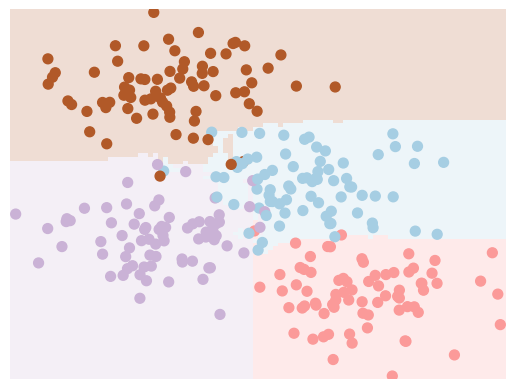

In [17]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# make dataset
X, y = make_blobs(n_samples=300, 
                  centers=4, random_state=0, 
                  cluster_std=1.0)

# create a default, not-trained model
# select classifier by commenting and un-commenting following code

# DecisionTreeClassifier
#print("DecisionTreeClassfier...")
#clf = DecisionTreeClassifier()

# RandomForestClassifier
print("RandomForestClassifier...")
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=0
)

visualize_tree(clf, X, y, boundaries=False)

# split dataset in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33
)

# train model
clf.fit(X_train, y_train)

# make predictions
predictions = clf.predict(X_test)

# calculate accuracy and confusion matrix
score=accuracy_score(y_test, predictions)
print(f"score = {score:0.2f}")
print(f"confusion matrix:\n{confusion_matrix(y_test, predictions)}")

### Regularisatie van hyperparameters: `GridSearchCV`

Er is een zeer handige klasse in Scikit-learn, waarmee een uitgebreide zoekopdracht uitgezet wordt over een aantal opgegeven parameterwaarden: `sklearn.model_selection.GridSearchCV`.

Hier volgt een voorbeeld:

In [18]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# make dataset
X, y = make_blobs(
    n_samples=300, 
    centers=4, 
    random_state=42, 
    cluster_std=1.0
)
    
# split dataset in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33
)

# create a default classifier:
#print("DecisionTreeClassfier...")
#clf = DecisionTreeClassifier(
#    random_state=42
#)

print("RandomForestClassifier...")
clf = RandomForestClassifier(
    random_state=42
)

# specify the hyperparameters which needs to be fine-tuned...
parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}

# setup a grid-search...
# Note: scoring specify the strategy to evaluate the performance
#       of the cross-validated model on the test set.
# scoring values from sklearn.metric.get_score_names()
grid_search = GridSearchCV(
    estimator=clf, 
    param_grid=parameters,
    scoring="accuracy",   # specifies strategy performance
    cv=5,       # cross-validation splitting strategy
    n_jobs=-1,  # -1: use all CPU-cores
)
# do an exhaustive search over the specified parameter values
# for the classifier
grid_search.fit(X_train, y_train)

# print results
print(grid_search.best_params_)

RandomForestClassifier...
{'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}


#### Oefening: experimenteer met gridsearchCV parameters
Experimenteer met de gridsearchCV-parameters `scoring`, `cv` en `n_jobs` en reflecteer op de resultaten. Zelfstudie, geen voorbeeldoplossingen.

In [19]:
# EXTRA code: valid values for parameter 'scoring':
#from sklearn.metrics import get_scorer_names
#get_scorer_names()

---
## EXTRA: random forest kwaliteiten

Een *random forest* is een ensemble van *decision trees*, over het algemeen getraind via de *bagging* ensemble-methode, meestal met `max_samples` ingesteld op de grootte van de trainingsset.

De volgende code bewijst dat een *random forest* gelijk is aan een verzameling (*bag of*) decision trees:

In [21]:
from sklearn.ensemble import RandomForestClassifier

# moons dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# using a RandomForestClassifier:
rnd_clf = RandomForestClassifier(
    n_estimators=500, 
    max_leaf_nodes=16,
    n_jobs=-1, 
    random_state=42
)
# train and predict...
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [22]:
# using a BaggingClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, 
    n_jobs=-1, 
    random_state=42
)
# train and predict...
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

In [23]:
# compare the predictions
np.all(y_pred_bag == y_pred_rf) # -> True, same predictions

np.True_

#### Feature's belang

Een andere kwaliteit van *random forest* is dat ze het gemakkelijk maken om het **relatieve belang van elk kenmerk** te meten. Scikit-learn meet het belang van een kenmerk als een gewogen gemiddelde, waarbij het gewicht van elk knooppunt gelijk is aan het aantal trainingsmonsters dat eraan is gekoppeld.

Bijvoorbeeld, de volgende code traint een `RandomForestClassifier` op de Iris-gegevensset en berekent het belang van elke feature. 

Het lijkt erop dat de belangrijkste kenmerken de bloembladlengte (petal length, 44%) en breedte (petal width, 42%) zijn, terwijl de lengte en breedte van de kelkblaadjes (sepal) vrij onbelangrijk zijn (respectievelijk 11% en 2%).

In [24]:
from sklearn.datasets import load_iris

# load Iris dataset...
iris = load_iris(as_frame=True)
# make a random forest classifier...
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
# train the classifier...
rnd_clf.fit(iris.data, iris.target)
# calculate feature importance...
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Evenzo, als je een random forest classifier traint op de MNIST-dataset en het belang van elke pixel uitzet, krijg je volgend plaatje (heatmap).

NB. Het duurt even voordat training en plot gemaakt zijn.

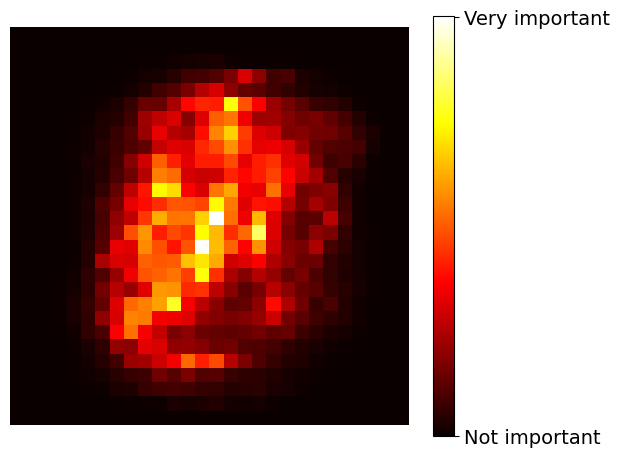

In [25]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml(
    'mnist_784', 
    return_X_y=True,
    as_frame=False
)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(
    ['Not important', 'Very important'],
    fontsize=14
)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

Random forests zijn erg handig om snel te begrijpen dat features er echt toe doen, vooral als je feature-selectie moet uitvoeren.

---